# Total Correlation Estimation

In this experiment, we evaluate performance of our Line-like and Tree-like total correlation (TC) estimators based on different mutual information (MI) estimators. 
First, we draw samples from multivariate Gaussian and Cubic distributions with the true TC values pre-known. Then we compare different MI estimators on estimating MI values based on the generated samples. 

In [2]:
import numpy as np
import time

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'



To obtain multivariate samples with known TC values, we follow the sampler we used for MI estimation simluation (check the details at https://github.com/Linear95/CLUB/mi_estimation.ipynb)

In [3]:
def sample_correlated_gaussian(rho=0.5, dim=20, sample_size=128, cubic = False):
    """Generate samples from a correlated Gaussian distribution."""
    mean = [0,0]
    cov = [[1.0, rho],[rho, 1.0]]
    x, y = np.random.multivariate_normal(mean, cov, sample_size * dim).T

    x = x.reshape(-1, dim)
    y = y.reshape(-1, dim)

    if cubic:
        y = y ** 3

    return x, y

With above defined two-variable sampler, we build two new samplers for three variables and four variables:

In [4]:
def triple_correlated_gaussian(rho, dim, which_dim, batch_size, to_cuda, cubic=False):
    '''
    jointly sample data for three variables
    rho : is the correlation coefficient
    which_dim: determine which dim to be independent to the others
    '''
    x1, x2 = sample_correlated_gaussian(rho, dim, batch_size, to_cuda=False, cubic=False)
    x3 = np.random.normal(size=(batch_size, dim))
    if which_dim == 0:
        outputs = np.stack([x3,x1,x2], axis = 1)
    elif which_dim == 1:
        outputs = np.stack([x1,x3,x2], axis = 1)
    elif which_dim == 2:
        outputs = np.stack([x1,x2,x3], axis = 1)
    if to_cuda:
        outputs = torch.from_numpy(outputs).float().cuda()

    return outputs

def four_correlated_gaussian(rho, dim, which_dim, batch_size, to_cuda, cubic=False):
    '''
    jointly sample data for four variables
    rho : is the correlation coefficient
    which_dim: determine which dim to be independent to the others
    '''
    x1, x2 = sample_correlated_gaussian(rho, dim, batch_size, to_cuda=False, cubic=False)
    x3 = np.random.normal(size=(batch_size, dim))
    x4 = np.random.normal(size=(batch_size, dim))
    if which_dim == 0:
        outputs = np.stack([x3,x1,x2,x4], axis = 1)
    elif which_dim == 1:
        outputs = np.stack([x1,x3,x2,x4], axis = 1)
    elif which_dim == 2:
        outputs = np.stack([x1,x2,x3,x4], axis = 1)
    if to_cuda:
        outputs = torch.from_numpy(outputs).float().cuda()

    return outputs




Under the Gaussian distribution, the correlation coefficient and mutual information have [one-to-one](https://en.wikipedia.org/wiki/Mutual_information#Linear_correlation) mapping:

In [5]:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho **2)
    return result


def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

In [6]:
def sample_multivariate_gaussian_given_TC(tc_value, var_num, sample_size=128, dim=10, cubic=False):
    '''
    return np array with shape [sample_size, var_num, dim]
    '''
    if var_num < 1:
        print("ERROR: number of variable cannot be smaller than 1.")
    elif var_num == 1:
        return np.random.normal(size=(sample_size, 1, dim))
    elif var_num == 2:
        rho = mi_to_rho(tc_value, dim)
        
        mean = [0,0]
        cov = [[1.0, rho],[rho, 1.0]]
        x, y = np.random.multivariate_normal(mean, cov, sample_size * dim).T

        x = x.reshape(-1, 1, dim)
        y = y.reshape(-1, 1, dim)
            
        return np.concatenate([x,y], axis=1)
    elif var_num == 3:
        x = sample_multivariate_gaussian_given_TC(0., 1, sample_size=sample_size, dim=dim, cubic=cubic)
        y = sample_multivariate_gaussian_given_TC(tc_value, 2, sample_size=sample_size, dim=dim, cubic=cubic)
        return np.concatenate([x,y], axis=1)
    
    else:
        left_var_num = var_num//2
        right_var_num = var_num - left_var_num
        x = sample_multivariate_gaussian_given_TC(tc_value/2., left_var_num, sample_size=sample_size, dim=dim, cubic=cubic)
        y = sample_multivariate_gaussian_given_TC(tc_value/2., right_var_num, sample_size=sample_size, dim=dim, cubic=cubic)
        return np.concatenate([x,y], axis=1)
        

In [11]:
from tc_estimators import TCLineEstimator, TCTreeEstimator

sample_dim = 20
batch_size = 64
hidden_size = 15
learning_rate = 0.001
training_steps = 4000

var_num = 4
cubic = False 
#model_list = ["NWJ", "MINE", "InfoNCE","L1OutUB","CLUB","CLUBSample"]
mi_est_names = ["CLUBMean","MINE","NWJ","InfoNCE"]
#model_list = ["InfoNCE"]

tc_value_list = [2.0, 4.0, 6.0, 8.0, 10.0]

total_steps = training_steps*len(tc_value_list)

In [12]:
model = TCLineEstimator(
        num_var=var_num, 
        dim=sample_dim, 
        hidden_size=hidden_size, 
        mi_est_name='CLUBMean'
    )

Train different TC estimators with samples drawn from different Gaussian distributions with different TC true values:

In [ ]:
# train MI estimators with samples 

est_results = dict()
for i, model_name in enumerate(mi_est_names):
    
    model = TCLineEstimator(
        num_var=var_num, 
        dim=sample_dim, 
        hidden_size=hidden_size, 
        mi_est_name=model_name
    )
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    tc_est_values = []
    start_time = time.time()
    for i, tc_value in enumerate(tc_value_list):
        rho = mi_to_rho(tc_value, sample_dim)

        for step in range(training_steps):
            #batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size = batch_size, to_cuda = True, cubic = cubic)
            #samples = four_correlated_gaussian(rho, dim=sample_dim, which_dim=1, batch_size=batch_size, to_cuda=True, cubic=False)
            samples = sample_multivariate_gaussian_given_TC(tc_value, var_num=var_num, sample_size=batch_size, dim=sample_dim, cubic=cubic)
            samples = torch.tensor(samples).float().to(device)
            model.eval()
            #samples = torch.stack([batch_x, batch_y], dim=1) #[batch,2,dim]
            tc_est_values.append(model(samples).item())
            
            model.train() 
            model_loss = model.learning_loss(samples)
           
            optimizer.zero_grad()
            model_loss.backward()
            optimizer.step()
            
            del samples
            torch.cuda.empty_cache()

        print("finish training for %s with true TC value = %f" % (model.__class__.__name__, tc_value))
        # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))
        torch.cuda.empty_cache()
    end_time = time.time()
    time_cost = end_time - start_time
    print("model %s average time cost is %f s" % (model_name, time_cost/total_steps))
    est_results[model_name] = tc_est_values

finish training for TCLineEstimator with true TC value = 2.000000
finish training for TCLineEstimator with true TC value = 4.000000
finish training for TCLineEstimator with true TC value = 6.000000
finish training for TCLineEstimator with true TC value = 8.000000
finish training for TCLineEstimator with true TC value = 10.000000
model CLUBMean average time cost is 0.008265 s
finish training for TCLineEstimator with true TC value = 2.000000
finish training for TCLineEstimator with true TC value = 4.000000
finish training for TCLineEstimator with true TC value = 6.000000
finish training for TCLineEstimator with true TC value = 8.000000
finish training for TCLineEstimator with true TC value = 10.000000
model MINE average time cost is 0.010314 s
finish training for TCLineEstimator with true TC value = 2.000000
finish training for TCLineEstimator with true TC value = 4.000000
finish training for TCLineEstimator with true TC value = 6.000000
finish training for TCLineEstimator with true TC v

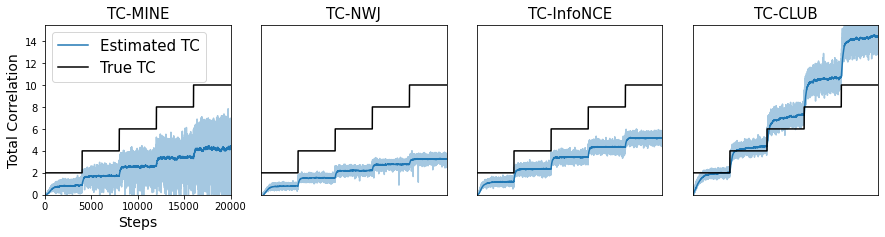

In [8]:
import seaborn as sns
import pandas as pd
colors = sns.color_palette()

EMA_SPAN = 200

model_list = mi_est_names

ncols = len(model_list)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 *ncols , 3.4 * nrows))
axs = np.ravel(axs)


xaxis = np.array(list(range(total_steps)))
yaxis_mi = np.repeat(mi_list, training_steps)

for i, model_name in enumerate(model_list):
    plt.sca(axs[i])
    p1 = plt.plot(mi_results[model_name], alpha=0.4, color=colors[0])[0]  #color = 5 or 0
    mis_smooth = pd.Series(mi_results[model_name]).ewm(span=EMA_SPAN).mean()
    
    if i == 0:
        plt.plot(mis_smooth, c=p1.get_color(), label='Estimated TC')
        plt.plot(yaxis_mi, color='k', label='True TC')
        plt.xlabel('Steps', fontsize= 14)
        plt.ylabel('Total Correlation', fontsize = 14)
        plt.legend(loc='upper left', prop={'size':15})
    else:
        plt.plot(mis_smooth, c=p1.get_color())
        plt.yticks([])
        plt.plot(yaxis_mi, color='k')
        plt.xticks([])
    
    plt.ylim(0, 15.5)
    plt.xlim(0, total_steps)   
    plt.title('TC-'+model_name, fontsize=15)
    #plt.subplots_adjust( )

plt.gcf().tight_layout()
#plt.savefig('mi_est_Gaussian.pdf', bbox_inches=None)

Calculate the bias, variance and mean-squared-error (MSE) of the estimated TC to the true TC values:

In [10]:
bias_dict = dict()
var_dict = dict()
mse_dict = dict()
for i, model_name in enumerate(model_list):
    bias_list = []
    var_list = []
    mse_list = []
    for j in range(len(mi_list)):
        mi_est_values = mi_results[model_name][training_steps*(j+1)- 500:training_steps*(j+1)]
        est_mean = np.mean(mi_est_values)
        bias_list.append(np.abs(mi_list[j] - est_mean))
        var_list.append(np.var(mi_est_values))
        mse_list.append(bias_list[j]**2+ var_list[j])
    bias_dict[model_name] = bias_list
    var_dict[model_name] = var_list
    mse_dict[model_name] = mse_list

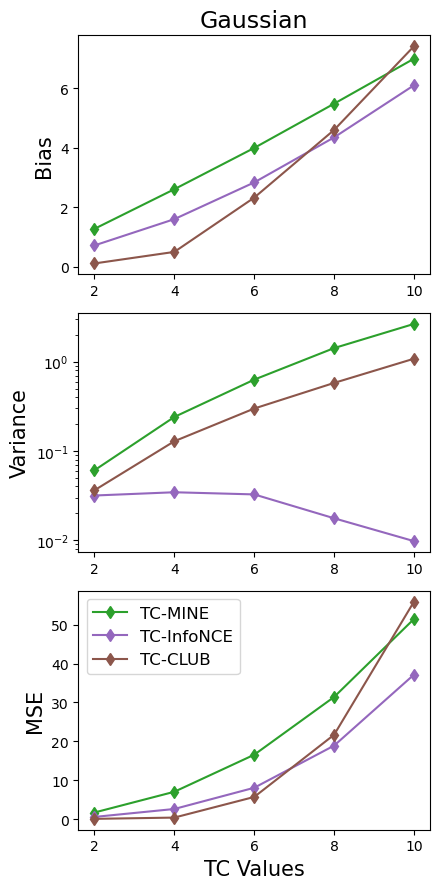

In [12]:
plt.style.use('default')#('seaborn-notebook')

colors = list(plt.rcParams['axes.prop_cycle'])
col_idx = [2,4,5,1,3,0]

ncols = 1
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3. * nrows))
axs = np.ravel(axs)

for i, model_name in enumerate(model_list):
    plt.sca(axs[0])
    plt.plot(mi_list, bias_dict[model_name], label='TC-'+model_name, marker='d', color = colors[col_idx[i]]["color"]) 
    
    plt.sca(axs[1])
    plt.plot(mi_list, var_dict[model_name], label='TC-'+model_name, marker='d', color = colors[col_idx[i]]["color"]) 
    
    plt.sca(axs[2])
    plt.plot(mi_list, mse_dict[model_name], label='TC-'+model_name, marker='d', color = colors[col_idx[i]]["color"]) 
        
ylabels = ['Bias', 'Variance', 'MSE']
for i in range(3):
    plt.sca(axs[i])
    plt.ylabel(ylabels[i], fontsize=15)
    
    if i == 0:
        if cubic:
            plt.title('Cubic', fontsize=17)
        else:
            plt.title('Gaussian', fontsize=17)
    if i == 1:
        plt.yscale('log')
    if i == 2:
        plt.legend(loc='upper left', prop={'size': 12})
        plt.xlabel('TC Values',fontsize=15)
        
plt.gcf().tight_layout()
#plt.savefig('bias_variance_Gaussian.pdf', bbox_inches='tight')